# Aligning Empatica / EEG on Audio

In [1]:
import os,sys
import shutil
import re
import json
import numpy as np
import pandas as pd
import audiofile
from tqdm import tqdm
import time
import datetime
from glob import glob
import textgrid
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import IPython

# google timeout
from requests import ConnectionError

# SPPAS
SPPAS_PATH = "/Users/eliot/Documents/tools/SPPAS"
sys.path.append(SPPAS_PATH)
# reading / writing textgrids
import sppas.src.anndata.aio.readwrite as spp
import sppas.src.anndata as sad
# searching for IPUs
import sppas
from sppas.src.annotations import sppasParam, sppasAnnotationsManager
from sppas.src.plugins import sppasPluginsManager

2022-11-13 15:00:29,130 [INFO] Logging redirected to StreamHandler (level=15).
2022-11-13 15:00:29,130 [INFO] Check directories and create if not existing:
2022-11-13 15:00:29,131 [INFO]  - Write access to SPPAS package directory is granted.
2022-11-13 15:00:29,131 [INFO]  - The folder for logs is OK.
2022-11-13 15:00:29,132 [INFO]  - The folder for the workspaces is OK.
2022-11-13 15:00:29,132 [INFO]  - The trash is OK.
2022-11-13 15:00:29,177 [WARNING] Support of images is disabled because it requires image feature.
2022-11-13 15:00:29,178 [WARNING] Support of videos is disabled because it requires video feature.
2022-11-13 15:00:29,181 [WARNING] The OS didn't defined a valid default locale.
2022-11-13 15:00:29,182 [WARNING] The OS didn't defined a valid default locale.
2022-11-13 15:00:29,182 [WARNING] The OS didn't defined a valid default locale.
2022-11-13 15:00:29,183 [WARNING] The OS didn't defined a valid default locale.
2022-11-13 15:00:29,183 [WARNING] The OS didn't defined a

In [4]:
try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

#from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def get_mel(audio, device=DEVICE):
    audio = whisper.pad_or_trim(audio.flatten()).to(device) 
    # docstring: whisper.pad_or_trim(array, length: int = 480000, *, axis: int = -1)
    mel = whisper.log_mel_spectrogram(audio)
    return mel

def resample_audio(audio, orig_fs:int, target_fq:int=16000, device=DEVICE):
    if not isinstance(audio, torch.Tensor):
        audio = torch.Tensor(audio, device=device)
    # resample
    rs = torchaudio.transforms.Resample(orig_freq=orig_fs, new_freq=target_fq)
    return rs(audio)

In [6]:
filepath = "~/Downloads/tmp/bkt-pilot-221103-audio.wav"

Using longer sequences of audio (using window):

In [92]:
audio_duration = audiofile.duration(filepath)
audio, fs = audiofile.read(filepath, always_2d=True)
nb_channels = audiofile.channels(filepath)
audio = resample_audio(audio, fs)
audio.shape

torch.Size([2, 43259200])

## Locating bip in audio

In [285]:
IPython.display.Audio(data = audio[:, 0:(30*16000)], rate=16000)

<AxesSubplot:>

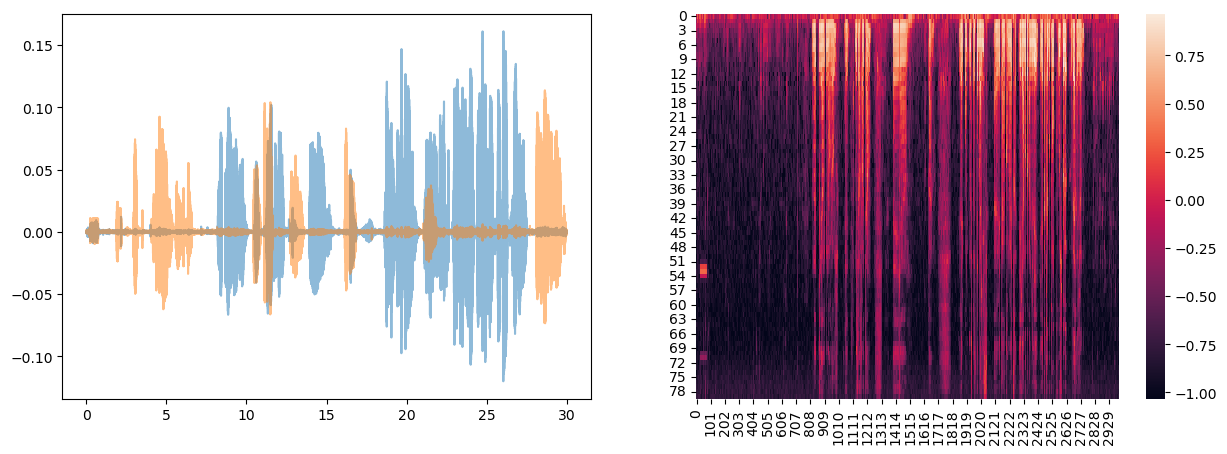

In [291]:
# plotting examples
nb_tens = 3
sound_ex = dataset.audio[:, 0:(nb_tens*10*16000)]
fig, ax = plt.subplots(1,2, figsize=(15,5))
# audio
t = np.arange(0,nb_tens*10,1/16000)
for i in range(audio.shape[0]):
    ax[0].plot(t, sound_ex[i,:], alpha=0.5)
# heatmap 
sound_ex = torch.Tensor(sound_ex)
sns.heatmap(get_mel(sound_ex)[:,:(1000*nb_tens)], ax=ax[1])

Notes:
* `get_mel()` adds padding to 30s - corresponds to extra black in the spectrogram
* return shape is **(80,3000)** for 30s hence **100Hz**
* looking for markers of duration ~0.5s <=> ~50 samples

Best indexes:  tensor([53, 52, 54,  1,  0,  2,  3, 71,  4,  6])


Text(0.5, 1.0, 'Mel coef 71')

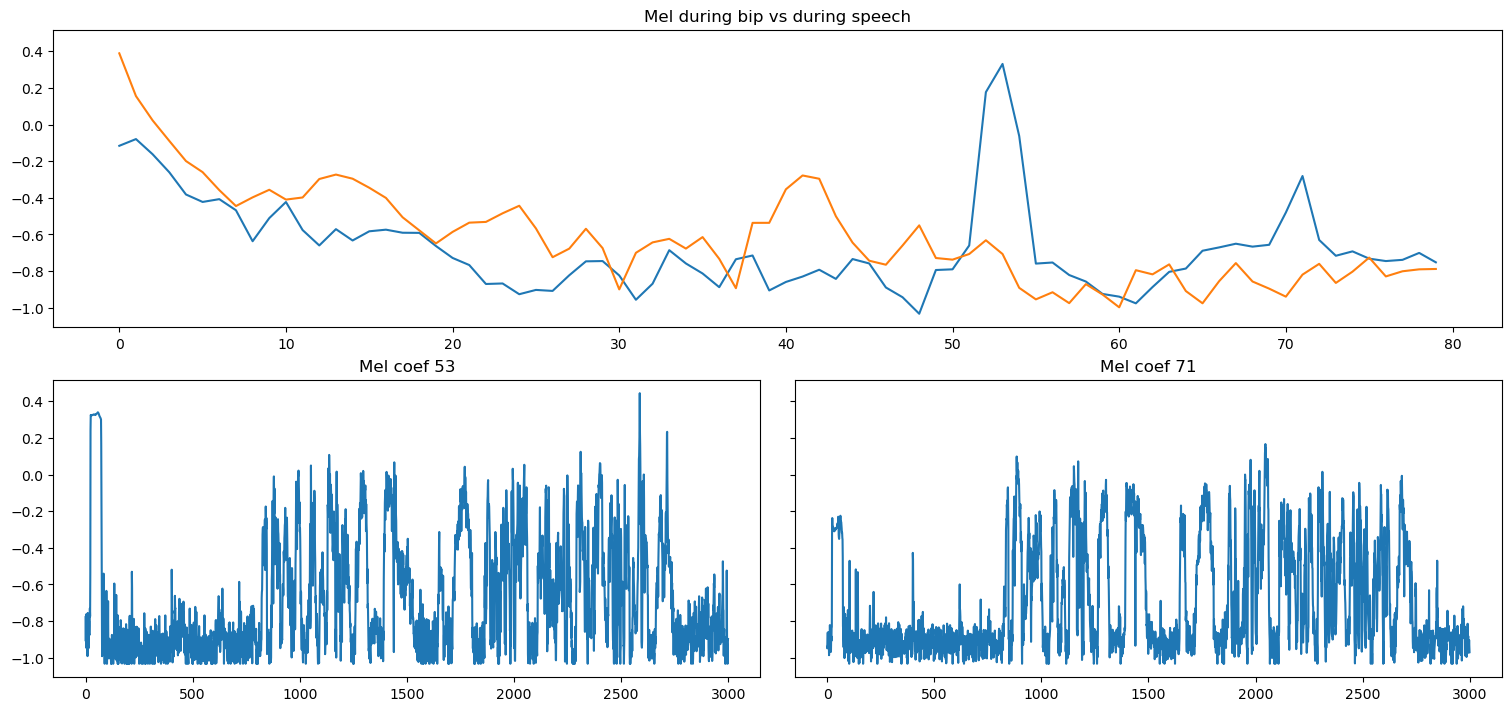

In [288]:
fig, axd = plt.subplot_mosaic([['upper', 'upper'],
                    ['lower left', 'lower right']], figsize=(15,7), layout="constrained", sharey=True)
mel = get_mel(sound_ex)
print('Best indexes: ', mel[:, 50].argsort()[-10:].flip(-1))
axd['upper'].plot(mel[:, 50])
axd['upper'].plot(mel[:, 2064])
axd['upper'].set_title('Mel during bip vs during speech')
axd['lower left'].plot(mel[53,:(1000*nb_tens)], label='x')
axd['lower left'].set_title('Mel coef 53')
axd['lower right'].plot(mel[71,:(1000*nb_tens)], label='y')
axd['lower right'].set_title('Mel coef 71')

In [339]:
# get_mel() uses `pad_or_trim()` to 30s - and returns 3000 samples => 100Hz
# doc: https://github.com/openai/whisper/blob/main/whisper/audio.py

def locate_markers(audio, mel_row:int=53, t_mel=None, 
                mk_min_duration:float=0.4, mk_min_value:float=0.2, 
                mk_max_std:float=0.15, **kwargs):
    mel_col = f'mel_{mel_row}'
    window = int(mk_min_duration*100) # 100 Hz - nb of frames
    # computing mel and creating df with times
    mel = get_mel(audio)
    if t_mel is None:
        t_mel = np.arange(0,30,1/100)
    mel_p = pd.DataFrame(np.array([t_mel, mel[mel_row,:].detach().numpy()]).T, columns=['start', mel_col])
    # rolling window to locate bip
    df = mel_p.rolling(window=window, center=False)
    dfp = pd.concat([df.min()['start'], df.mean()[mel_col], df.std()[mel_col]], axis=1).dropna()
    dfp.columns = ['start', 'mean','std']
    # selecting values and keeping first one
    dfp_m = dfp[(dfp['mean'] > mk_min_value) & (dfp['std'] < mk_max_std)].reset_index(drop=False)
    dfp_m['new_start'] = (dfp_m.start - dfp_m.start.shift(1)).fillna(10.) > 1.
    return dfp_m[dfp_m.new_start]

def locate_markers_all(audio, fs:int=16000, **kwargs):
    # using 30s chunks since that's whisper's default
    idx = list(range(0,audio.shape[1], int(fs*30/2))) # window definitions - includes overlap
    if (audio.shape[1]-1) not in idx:
        idx.append(audio.shape[1]-1)
    dfp_m = None
    for i in tqdm(range(len(idx)-2)): 
        start = idx[i]
        stop = idx[i+2]
        sound_ex = audio[:, start:stop] # +2 since overlap
        t_mel = np.arange(start/fs,(start/fs+30),1/100) # needs to be 30s even for the last one
        res_m = locate_markers(sound_ex, t_mel = t_mel, **kwargs)
        # adding to prev results
        if res_m.shape[0] > 0:
            dfp_m = res_m if dfp_m is None else pd.concat([dfp_m, res_m], axis=0)
    # removing overlap
    dfp_m = dfp_m.drop_duplicates(subset=['start','mean','std'])
    # removing extra (from padding)
    dfp_m = dfp_m[dfp_m['start'] < (audio.shape[1]/fs)].reset_index(drop=True)
    return dfp_m

In [329]:
locate_markers(sound_ex)

,index,start,mean,std,new_start
0,61,0.22,0.305134,0.137215,True


In [340]:
dfp_m = locate_markers_all(torch.Tensor(dataset.audio))
dfp_m.iloc[[0,-1]]

100%|██████████| 180/180 [00:01<00:00, 131.35it/s]


,index,start,mean,std,new_start
0,61,0.22,0.305134,0.137215,True
17,1697,2701.58,0.262598,0.148396,True


## Loading EEG / Watches
* Markers audio <> EEG
* Timestamps EEG <> watches

In [341]:
import mne
%matplotlib qt

In [526]:
bdf_file = "pilot-bkt-221103"
#bdf_file = "pilot_25-8-2020"
data = mne.io.read_raw_bdf(f"../../Downloads/tmp/{bdf_file}.bdf", preload=True) # mne as relative
data = data.drop_channels([x for x in data.ch_names if '-C' in x or '-D' in x or ('EXG' in x and int(x[-1]) not in [1,2,3] )])
data.set_channel_types({x:'bio' for x in data.ch_names if ('-A' not in x) and ('-B' not in x) and ('Status' not in x)})

Extracting EDF parameters from /Users/eliot/Downloads/tmp/pilot-bkt-221103.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5969919  =      0.000 ...  2915.000 secs...


<RawEDF | pilot-bkt-221103.bdf, 149 x 5969920 (2915.0 s), ~6.63 GB, data loaded>

In [527]:
#data.info
data.info['meas_date'], data.info['sfreq']

(datetime.datetime(2022, 11, 3, 10, 18, 32, tzinfo=datetime.timezone.utc),
 2048.0)

In [528]:
# resampling example: https://mne.tools/0.11/auto_examples/preprocessing/plot_resample.html
# https://mne.tools/stable/generated/mne.io.Raw.html
dt = data.resample(100)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]


In [376]:
dt.info

<Info | 7 non-empty values
 bads: []
 ch_names: 1-A1, 1-A2, 1-A3, 1-A4, 1-A5, 1-A6, 1-A7, 1-A8, 1-A9, 1-A10, ...
 chs: 148 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 2022-08-25 15:25:08 UTC
 nchan: 149
 projs: []
 sfreq: 100.0 Hz
>

In [533]:
markers_idx = mne.find_events(dt, stim_channel='Status')
markers_idx[np.where(markers_idx[:,2] == 1)[0]]

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]


array([[  1449,      0,      1],
       [270309,      0,      1],
       [271586,      0,      1]])

In [540]:
def raw_get_data(dt:mne.io.Raw, stim_channel:str='Status', event_value:int=1, resample_fq:int=None):
    # depending on use, might want to resample from 24kHz to lower
    if resample_fq is not None:
        # resampling example: https://mne.tools/0.11/auto_examples/preprocessing/plot_resample.html
        # https://mne.tools/stable/generated/mne.io.Raw.html
        dt = dt.resample(resample_fq)
    # copy data and add bool column for markers
    dtp = dt.to_data_frame()
    markers_idx = mne.find_events(dt, stim_channel=stim_channel)
    # TODO: check in new data which events
    markers_idx = markers_idx[np.where(markers_idx[:,2] == 1)[0]]
    markers_idx = markers_idx[:,0]
    # removing other markers
    dtp['marker'] = False
    dtp.loc[markers_idx,'marker'] = True
    # returns a dataframe, not yet aligned to the audio signal
    return dtp

def _check_duration(audio_triggers:pd.DataFrame, eeg_triggers:pd.DataFrame,
            audio_time_col:str='start', eeg_time_col:str='time', dec_round:int=1, **kwargs):
    # check time difference between first and last triggers
    au = audio_triggers[audio_time_col].iloc[[0,-1]].tolist()
    eg = eeg_triggers[eeg_time_col].iloc[[0,-1]].tolist()
    au_td = np.round(au[1] - au[0], decimals=dec_round)
    eg_td = np.round(eg[1] - eg[0], decimals=dec_round)
    print(f"Durations (no rounding): audio {au[1] - au[0]} - eeg {eg[1] - eg[0]}")
    if au_td != eg_td:
        # note: round the biggest one to the smallest one
        raise ValueError(f"Please review triggers to use: duration in audio: {au_td}s - in eeg: {eg_td}s")
    # check number of triggers in each
    print(audio_triggers.shape[0], eeg_triggers.shape[0])
    # return the first triggers
    return au[0], eg[0]

def _align_eeg(audio_data:pd.DataFrame, eeg_data:pd.DataFrame, 
            audio_time_col:str='start', eeg_time_col:str='time', **kwargs):
    audio_triggers = locate_markers_all(torch.Tensor(audio_data))
    eeg_triggers = eeg_data[eeg_data.marker]
    fs = 1/(eeg_data[eeg_time_col].iloc[1] - eeg_data[eeg_time_col].iloc[0])
    audio_first_trig, eeg_first_trig = _check_duration(audio_triggers, eeg_triggers, audio_time_col, eeg_time_col, **kwargs)
    eeg_data['time_align'] = (eeg_data[eeg_time_col] - eeg_first_trig + audio_first_trig).apply(lambda x: np.round(x, int((fs // 10)+1)))
    return eeg_data[(eeg_data.time_align >= 0)] # TODO: & (eeg_data.time_align <= add dataset.audio_duration)

def get_eeg(eeg_data:pd.DataFrame, s_start:float, s_stop:float, 
            eeg_timealign_col:str='time_align', select_cols:list=None):
    if select_cols is None: 
        select_cols = eeg_data.columns
    return eeg_data[select_cols][(eeg_data[eeg_timealign_col] >= s_start) & (eeg_data[eeg_timealign_col] <= s_stop)]

In [541]:
dtp_test = raw_get_data(data, resample_fq=100)
_check_duration(dfp_m, dtp_test[dtp_test.marker])

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7 events found
Event IDs: [    1 65536]
Durations (no rounding): audio 2701.360000000362 - eeg 2701.3700000000003
18 3


(0.22, 14.49)

In [404]:
fs = 1/(dtp['time'].iloc[1] - dtp['time'].iloc[0])
int((fs // 10)+1)

11.0

In [400]:
print(dtp['time'].loc[612], eeg_first_trig, audio_first_trig, dtp['time'].loc[612] - eeg_first_trig + audio_first_trig)

6.12 6.34 0.22 2.498001805406602e-16


In [405]:
audio_first_trig, eeg_first_trig = _check_duration(dfp_m, dtp[dtp.marker])
dtp['time_align'] = (dtp['time'] - eeg_first_trig + audio_first_trig).apply(lambda x: np.round(x, int((fs // 10)+1)))
dtp[(dtp.time_align >= 0) & ()]

2701.360000000362 2707.56
18 81


,time,1-A1,1-A2,1-A3,1-A4,1-A5,1-A6,1-A7,1-A8,1-A9,...,2-GSR1,2-GSR2,2-Erg1,2-Erg2,2-Resp,2-Plet,2-Temp,Status,marker,time_align
612,6.12,-13908.900146,-14684.229756,4119.093961,69.851895,-138.345243,-3635.336329,-9971.190500,-1.980815,1978.637835,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,0.00
613,6.13,-13898.647611,-14674.347566,4126.760455,74.428094,-133.600325,-3631.140843,-9963.103512,7.578367,1988.633201,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,0.01
614,6.14,-13908.106219,-14685.001316,4120.804057,71.478660,-133.447432,-3628.499424,-9970.156827,6.785385,1986.081786,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,0.02
615,6.15,-13911.640393,-14694.739011,4116.878764,69.055223,-139.213616,-3639.458995,-9981.392887,5.067186,1975.545459,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,0.03
616,6.16,-13910.752928,-14690.648443,4117.732010,67.892836,-143.311691,-3645.891186,-9968.445294,7.535114,1973.049396,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272795,2727.95,-6510.958764,-6170.011291,2455.324040,-2484.013494,-1077.391155,-1057.112818,-3553.072119,-403.208273,9773.107540,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,2721.83
272796,2727.96,-6512.358600,-6188.249117,2450.939129,-2489.194754,-1083.591096,-1060.467168,-3552.528218,-416.722237,9761.569179,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,2721.84
272797,2727.97,-6515.288559,-6198.590359,2443.690524,-2495.309185,-1090.384657,-1065.925622,-3553.713381,-423.083617,9753.761725,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,2721.85
272798,2727.98,-6505.639192,-6165.575361,2460.374288,-2480.632017,-1075.294361,-1047.938406,-3542.484309,-388.126956,9782.170403,...,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,65532.0,False,2721.86


In [521]:
dataset.audio_duration

2703.68

In [390]:
dtp = dt.to_data_frame()
markers_idx = mne.find_events(dt, stim_channel='Status')[:,0]
# removing other markers
dtp['marker'] = False
dtp.loc[markers_idx,'marker'] = True
dtp['aligned_time'] = dt.info['sfreq']
dtp.head()

Trigger channel has a non-zero initial value of 131068 (consider using initial_event=True to detect this event)
81 events found
Event IDs: [65533 65534]


,time,1-A1,1-A2,1-A3,1-A4,1-A5,1-A6,1-A7,1-A8,1-A9,...,2-EXG3,2-GSR1,2-GSR2,2-Erg1,2-Erg2,2-Resp,2-Plet,2-Temp,Status,marker
0,0.00,-13921.109127,-14716.134237,4131.064086,45.259622,-112.515621,-3614.383561,-9989.049934,-4.052921,1981.125800,...,-20414.982881,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,131068.0,False
1,0.01,-13928.462425,-14729.457565,4111.222820,26.675581,-150.513648,-3664.337101,-10009.166067,-2.575033,1915.588909,...,-20419.769142,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,131068.0,False
2,0.02,-13933.784893,-14730.480139,4110.307438,28.235496,-138.984102,-3652.293422,-10006.651435,-12.931855,1938.369011,...,-20397.439875,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,131068.0,False
3,0.03,-13931.761789,-14729.801582,4110.269974,26.560684,-143.394643,-3653.164180,-9998.968862,-13.549385,1941.978903,...,-20399.927416,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,131068.0,False
4,0.04,-13929.472919,-14724.640291,4118.020517,33.102413,-131.246081,-3638.910145,-10016.328952,-9.162025,1947.392083,...,-20394.108707,2.621430e+11,2.621430e+11,-0.375,-0.375,-0.375,-62.744137,7.653396e+06,131068.0,False


### Align watch to EEG

In [408]:
watch_paths_pat = "/Users/eliot/Documents/data-raw/test-expe/pilote_25.08.2022/"
watch_path_part = {1: "montre_jorina.zip"}
watch_paths_ex = os.path.join(watch_paths_pat, watch_path_part[1])

In [411]:
if '.zip' in watch_paths_ex:
    shutil.unpack_archive(watch_paths_ex, watch_paths_ex[:-4])

In [513]:
# https://stackoverflow.com/questions/3451111/unzipping-files-in-python
def read_one_watch_data(watch_path, remove_once_complete:bool=True):
    """Reading data from Emotiv Files:
    * info.txt
    * tags.csv: each row = physical button press on the device (unix timestamp in UTC)
    * IBI.csv: inter-beat interval; time (1rst) and duration (2nd column) of the heart beat interval
    For each (other) file: 1rst row is the timestamp (UTC) of the session start; 2nd row is the sample rate (in Hz)
    * HR.csv
    * TEMP.csv
    * BVP.csv
    * EDA.csv
    * ACC.csv
    # note: HR starts after the others
    """
    # unzip if not folder
    if '.zip' in watch_path:
        shutil.unpack_archive(watch_path, watch_path[:-4])
    d = {'tags':[]}
    for file in ['HR', 'TEMP', 'BVP', 'EDA', 'ACC']:
        filepath = os.path.join(watch_path[:-4], f'{file}.csv')
        with open(filepath, 'r') as f:
            start_ts = float(f.readline().split(',')[0].replace('\n','')) # taking first for ACC
            fs = int(float(f.readline().split(',')[0].replace('\n','')))
        data = pd.read_csv(filepath, skiprows=2, header=None)
        data.columns = [file] if data.shape[1] == 1 else [f'{file}_{i}' for i in range(data.shape[1])]
        data['time'] = np.arange(0, data.shape[0]/fs, 1/fs)
        d[file] = {
            'start': start_ts, 'fs': fs, 'data': data
        }
    # adding tags
    with open(os.path.join(watch_path[:-4], 'tags.csv'), 'r') as f:
        for ts in f.readlines():
            ts = float(ts.split(',')[0].replace('\n',''))
            d['tags'].append(datetime.datetime.fromtimestamp(ts))
    # remove folder to preserve space / organisation
    if remove_once_complete:
        shutil.rmtree(watch_path[:-4])
    return d

def _aggregate_one_watch(one_watch_data:dict, unaligned:bool=True) -> pd.DataFrame:
    # aligning time using start_ts - unless already aligned
    if unaligned:
        starts = pd.Series({c: one_watch_data[c]['start'] for c in one_watch_data if c != 'tags'})
        min_ts = starts.min()
        starts = (starts - min_ts).to_dict()
        for c in one_watch_data:
            if c != 'tags':
                one_watch_data[c]['data']['time'] = one_watch_data[c]['data']['time'] + starts[c]
    df = pd.concat([one_watch_data[c]['data'].set_index('time') 
            for c in one_watch_data if c != 'tags'], ignore_index=False, axis=1).sort_index()
    return df.reset_index(), min_ts
    

def align_watch_data(watch_data, delay_to_eeg, delay_to_video, cut_on:str=None):
    # Note: using timestamps instead of datetime for praticity reasons - both are utc
    # align for every df
    # align for merge df
    if cut_on is not None:
    

def export_one_watch_data():
    pass
def read_watch_from_memory():
    pass

In [514]:
d = read_one_watch_data(watch_paths_ex)
for x in d:
    if x == 'tags':
        print('tags', d['tags'])
    else:
        # they also don't finish at the same time
        print(x, datetime.datetime.fromtimestamp(d[x]['start']), 'last_value', d[x]['data'].iloc[-1]['time'])

watch_agg, min_ts = _aggregate_one_watch(d)

tags [datetime.datetime(2022, 8, 25, 15, 12, 41, 90000)]
HR 2022-08-25 15:11:09 last_value 3450.0
TEMP 2022-08-25 15:10:59 last_value 3469.75
BVP 2022-08-25 15:10:59 last_value 3460.515625
EDA 2022-08-25 15:10:59 last_value 3460.25
ACC 2022-08-25 15:10:59 last_value 3461.03125


In [508]:
delay_to_eeg = data.info['meas_date'] - datetime.datetime.fromtimestamp(min_ts).replace(tzinfo=datetime.timezone.utc)
#delay_to_eeg = data.info['meas_date'].timestamp() - min_ts # 8049??
delay_to_eeg = delay_to_eeg.seconds
delay_to_video = delay_to_eeg + dtp[dtp.time_align >= 0].iloc[0]['time']

In [519]:
watch_agg['time_align_eeg'] = watch_agg['time'] - delay_to_eeg
watch_agg['time_align_video'] = watch_agg['time'] - delay_to_video
cut_on = 'video'
if cut_on is not None and f'time_align_{cut_on}' in watch_agg.columns:
    watch_agg = watch_agg[watch_agg[f'time_align_{cut_on}'] >= 0]

In [520]:
watch_agg.head()

,time,HR,TEMP,BVP,EDA,ACC_0,ACC_1,ACC_2,time_align_eeg,time_align_video
54728,855.125000,NaN,NaN,129.14,NaN,-43.0,-28.0,40.0,6.125000,0.005000
54729,855.140625,NaN,NaN,114.68,NaN,NaN,NaN,NaN,6.140625,0.020625
54730,855.156250,NaN,NaN,96.12,NaN,-43.0,-27.0,39.0,6.156250,0.036250
54731,855.171875,NaN,NaN,75.56,NaN,NaN,NaN,NaN,6.171875,0.051875
54732,855.187500,NaN,NaN,55.18,NaN,-44.0,-26.0,40.0,6.187500,0.067500


In [522]:
watch_agg.tail()

,time,HR,TEMP,BVP,EDA,ACC_0,ACC_1,ACC_2,time_align_eeg,time_align_video
221521,3468.75,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2619.75,2613.63
221522,3469.00,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.00,2613.88
221523,3469.25,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.25,2614.13
221524,3469.50,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.50,2614.38
221525,3469.75,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.75,2614.63


In [523]:
watch_agg[watch_agg.time_align_video <= dataset.audio_duration].tail()

,time,HR,TEMP,BVP,EDA,ACC_0,ACC_1,ACC_2,time_align_eeg,time_align_video
221521,3468.75,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2619.75,2613.63
221522,3469.00,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.00,2613.88
221523,3469.25,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.25,2614.13
221524,3469.50,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.50,2614.38
221525,3469.75,NaN,36.45,NaN,NaN,NaN,NaN,NaN,2620.75,2614.63
